In [3]:
####################################################################################################
# CR.Tau_QsiBias.ipynb
# Karl Lapo September/2015
####################################################################################################
# Plots bias in Qsi and Tau between ground observations and products
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dir_data = dir_pre+'SnowHydrology/proj/CloudClimatology/data'
dir_print = dir_pre+'SnowHydrology/proj/CloudClimatology/Graphics'

# Directory for basemap pickle files
dir_bmap = dir_pre+'SnowHydrology/proj/CloudClimatology/data/basemap'

In [4]:
####################################################################################################
# Load Data
####################################################################################################
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grobs_diff = xray.open_dataset('grobs_bias.daily.nc')
anom_day = xray.open_dataset('tau_anom.daily.nc')
anom_mon = xray.open_dataset('tau_anom.monthly.nc')
tau = xray.open_dataset('tau.daily.nc')

## Names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

## Transmissivity
tau_products = xray.Dataset()
full_pr_names = ['mtclim','nldas','syn','wrf','grobs']
for pr in full_pr_names:
    tau_products[pr] = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)

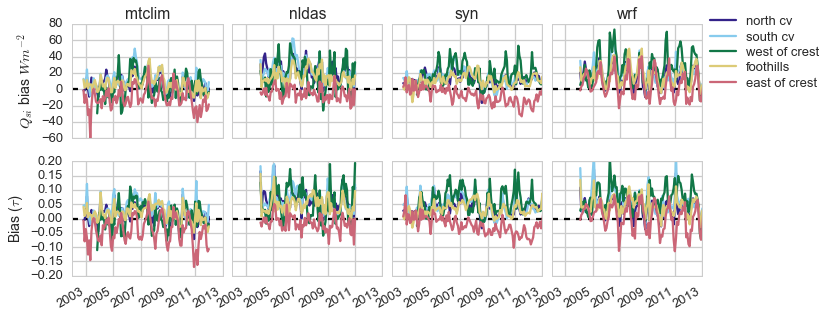

In [3]:
#####################################
## Time series of bias by Grouping ##
#####################################
# formating preface
colsche = kgraph.SRON(5)
fig = plt.figure(figsize=(12,5))
gs = matplotlib.gridspec.GridSpec(2,5,\
                                  width_ratios=np.array((5,5,5,5,1)))
gs.update(wspace=0.075)

for n,pr in enumerate(pr_names):
    ###################
    # Shortwave Bias ##
    ###################
    ax = plt.subplot(gs[0,n])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    
    ## Format Qsi bias
    ds_plot = grobs_diff[pr].resample(freq='M', dim='time', how='mean')
    
    for m,gr in enumerate(grouping):
        plt.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],color=colsche[m],label=gr)
    
    # Labels
    if n == 0:
        ax.set_ylabel('$Q_{si}$ bias $Wm^{-2}$')
        # Legend handles
        handles, labels = ax.get_legend_handles_labels()
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-60,80)
    ax.set_title(pr)
    
    ###################
    #    Tau Bias    ##
    ###################
    ax = plt.subplot(gs[1,n])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')

    ## Format tau bias
    tau_diff = (tau_products[pr]-tau_products.grobs).swap_dims({'station':'Grouping'})
    tau_diff = tau_diff.resample(freq='M', dim='time', how='mean')

    # Plot tau bias
    for m,gr in enumerate(grouping):
        plt.plot(tau_diff.time,tau_diff.loc[{'Grouping':gr}].mean('Grouping'),color=colsche[m],label=gr)
    
    # Labels
    if n == 0:
        ax.set_ylabel('Bias ($\\tau$)')
        # Legend handles
        handles, labels = ax.get_legend_handles_labels()
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-.2,.2)

    
# Legend
ax = plt.subplot(gs[0,-1])
ax.axis('off')
ax.legend(handles, labels,loc='center',ncol=1,\
                    labelspacing=.25,markerscale=1,numpoints=1,\
                    bbox_to_anchor=(1.5, .5, .5, .5))
fig.autofmt_xdate()

os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.groups.png'
fig.savefig(fname)


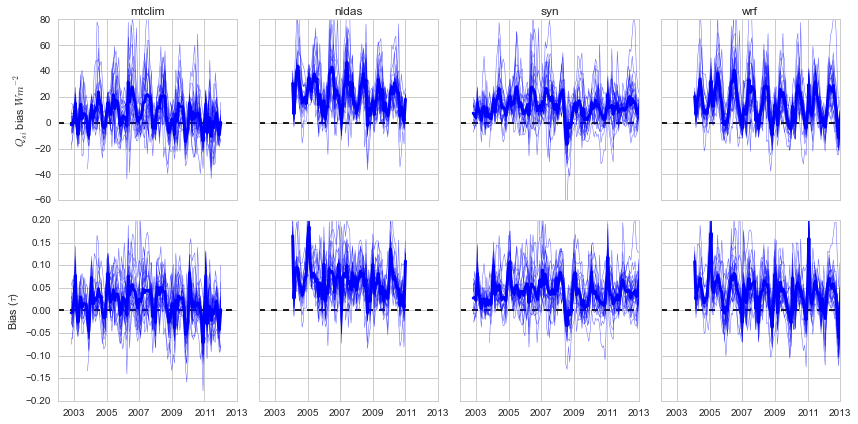

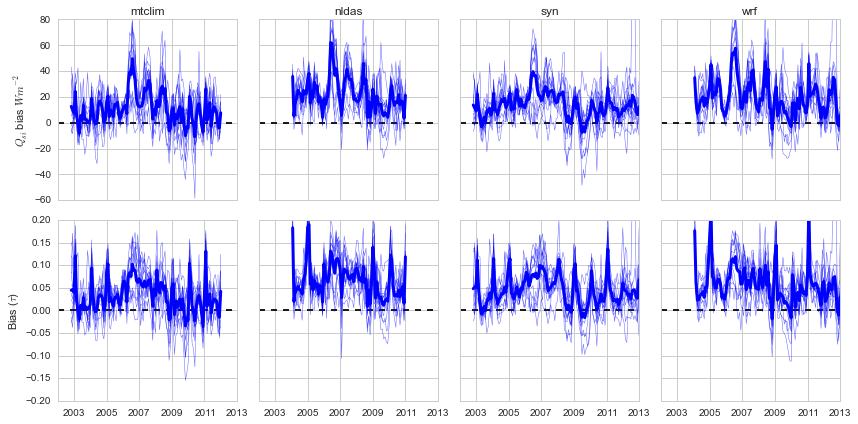

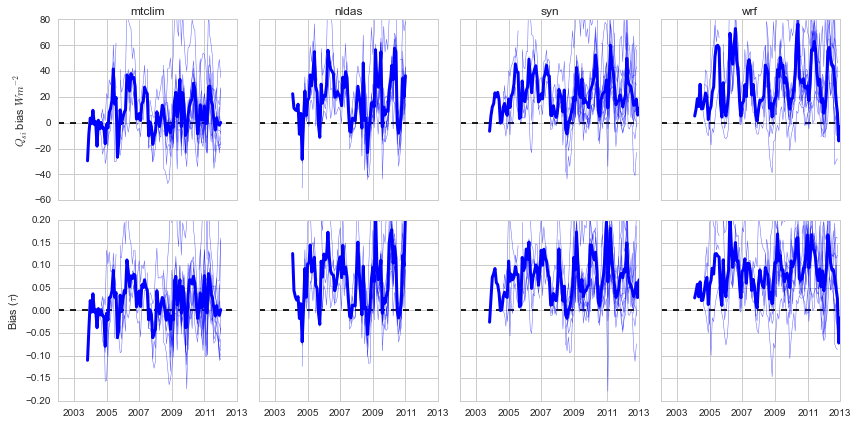

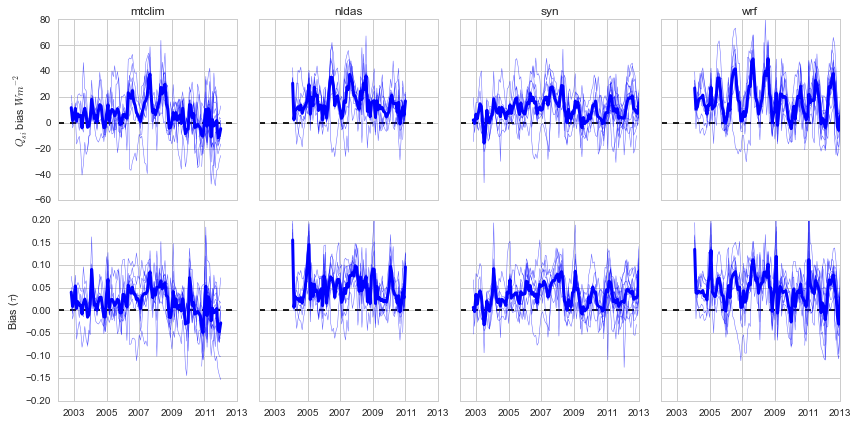

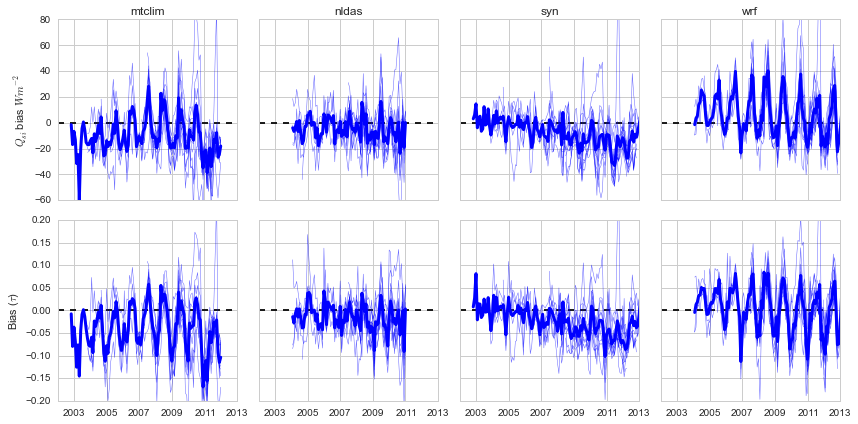

In [25]:
#########################################################
## Time series of bias by Grouping - Each individually ##
#########################################################
# formating preface
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
colsche = kgraph.SRON(5)

for n,gr in enumerate(grouping):
    fig, axes = plt.subplots(2,4,figsize=(12,6),sharex='col',sharey='row')
    for m,pr in enumerate(pr_names):
        ax = axes[0,m]
        
        ###################
        # Shortwave Bias ##
        ###################
        ## Format Qsi bias
        ds_plot = (grobs[pr]-grobs.grobs)
        ds_plot = ds_plot.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
        
        ax.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],\
                color='b',label=gr,alpha=.6,lw=.5)
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='b',label=gr,lw=3)


        # Labels
        if m == 0:
            ax.set_ylabel('$Q_{si}$ bias $Wm^{-2}$')
        ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
        ax.set_ylim(-60,80)
        ax.set_title(pr)
    
        ###################
        #    Tau Bias    ##
        ###################
        ax = axes[1,m]
        ax.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
        
        ## Format tau bias
        tau_diff = (tau_products[pr]-tau_products.grobs).swap_dims({'station':'Grouping'})
        tau_diff = tau_diff.resample(freq='M', dim='time', how='mean')
        
        ax.plot(tau_diff.time,tau_diff.loc[{'Grouping':gr}],\
                color='b',label=gr,alpha=.6,lw=.5)
        
        ax.plot(tau_diff.time,tau_diff.loc[{'Grouping':gr}].mean('Grouping'),\
                color='b',label=gr,lw=3)
    
        # Labels
        if m == 0:
            ax.set_ylabel('Bias ($\\tau$)')
        ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
        ax.set_ylim(-.2,.2)
    
    plt.tight_layout()
    os.chdir(dir_print)
    fname = 'SWdwn_Tau.MonthlyBias.'+gr+'.png'
    fig.savefig(fname)
#     plt.close(fig)


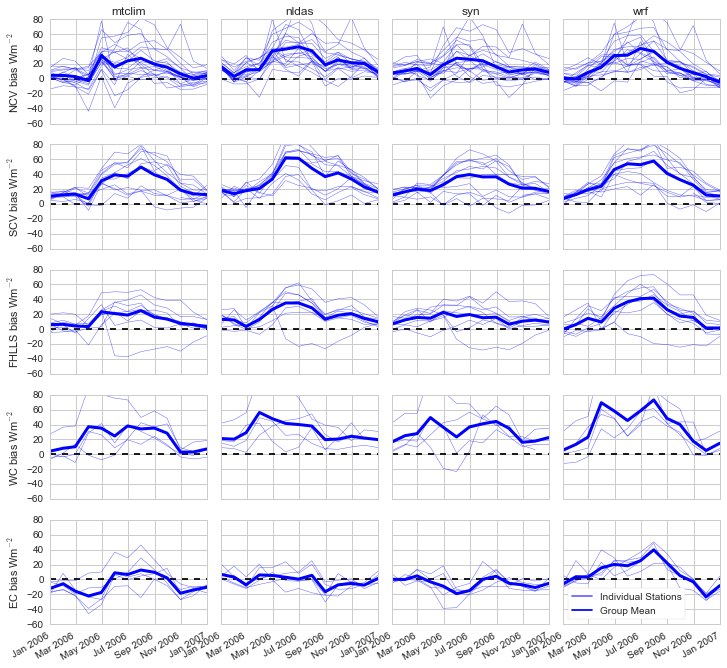

In [29]:
#########################################################
##      Time series of bias by Grouping - Panel        ##
#########################################################
# formating preface
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
grouping_shortlabel = ['NCV','SCV','FHLLS','WC','EC']
colsche = kgraph.SRON(5)

fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(5,4)
gs.update(wspace=0.09)

for n,gr in enumerate(grouping):
    for m,pr in enumerate(pr_names):
        if pr == 'grobs':
            continue
        ax = plt.subplot(gs[n,m])
        
        ###################
        # Shortwave Bias ##
        ###################
        ## Format Qsi bias
        ds_plot = (grobs[pr]-grobs.grobs)
        ds_plot = ds_plot.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
        
        ax.plot(np.array([datetime(2006,1,1),datetime(2007,1,1)]),np.array([0,0]),'k--')
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],\
                color='b',alpha=.6,lw=.5)
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='b',lw=3)
        
        # Labels - products
        if n == 0:
            ax.set_title(pr)
        # Labels - groups
        if m == 0:
            ax.set_ylabel(grouping_shortlabel[n]+' bias Wm$^{-2}$')
        else:
            ax.yaxis.set_ticklabels([])
        # Legend
        if n == 0 and m == 0:
            ax.legend(ncol=1)


        ax.set_xlim(datetime(2006,1,1),datetime(2007,1,1))
        ax.set_ylim(-60,80)
    
## Legend
import matplotlib.lines as mlines
label = ['Individual Stations','Group Mean']
alpha = np.array([.6,1])
h = [mlines.Line2D([],[],color='b',label=lab, alpha=a) \
            for a,lab in zip(alpha,label)]
leg = plt.legend(handles=h,loc='lower left',frameon=True)
fig.autofmt_xdate()
   
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.AllGroups.png'
fig.savefig(fname)
# plt.close(fig)

/home/lapok/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


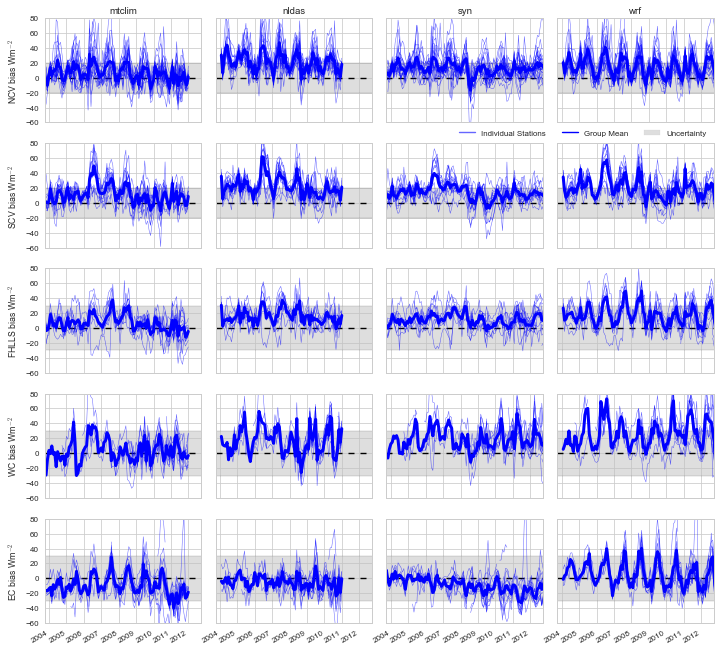

In [5]:
########################################################################
##      Time series of bias by Grouping - Panel w/ Uncertainty        ##
########################################################################
# formating preface
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
grouping_shortlabel = {'north cv':'NCV','south cv':'SCV','foothills':'FHLLS','west of crest':'WC','east of crest':'EC'}
grouping_uncertainty = {'north cv':20,'south cv':20,'foothills':30,'west of crest':30,'east of crest':30}
colsche = kgraph.SRON(5)


# Figure
fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(5,4)
gs.update(wspace=0.09)

# Date limits
d1 = datetime(2003,10,1)
d2 = datetime(2012,10,1)

for n,gr in enumerate(grouping):
    for m,pr in enumerate(pr_names):
        if pr == 'grobs':
            continue
        ax = plt.subplot(gs[n,m])
        
        ###################
        # Shortwave Bias ##
        ###################
        ## Format Qsi bias
        ds_plot = (grobs[pr]-grobs.grobs)
        ds_plot = ds_plot.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
 
        # Uncertainty estimate
        ax.fill_between(ds_plot.time.values,-grouping_uncertainty[gr],grouping_uncertainty[gr],\
                        facecolor='.75',alpha=.5)
        # Zero line
        ax.plot(np.array([d1,d2]),np.array([0,0]),'k--')
        # Each station
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],\
                color='b',alpha=.6,lw=.5)
        # Group mean
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='b',lw=3)
  
        # Labels - products
        if n == 0:
            ax.set_title(pr)
        # Labels - groups
        if m == 0:
            ax.set_ylabel(grouping_shortlabel[gr]+' bias Wm$^{-2}$')
        else:
            ax.yaxis.set_ticklabels([])
        # Legend
        if n == 0 and m == 0:
            ax.legend(ncol=1)
        # Axes limits
        ax.set_xlim(d1,d2)
        ax.set_ylim(-60,80)
    
## Legend
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
label = ['Individual Stations','Group Mean']
alpha = np.array([.6,1])
h = [mlines.Line2D([],[],color='b',label=lab, alpha=a) \
            for a,lab in zip(alpha,label)]
h.append(mpatches.Patch(color='.75',alpha=.5, label='Uncertainty'))
ax = plt.subplot(gs[0,3])
leg = ax.legend(handles=h,bbox_to_anchor=(.5, -.5, .5, .5),ncol=3)
fig.autofmt_xdate()
   
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.AllGroups.Uncertainty.pdf'
fig.savefig(fname)
fname = 'SWdwn_bias_monthly.AllGroups.Uncertainty.png'
fig.savefig(fname)

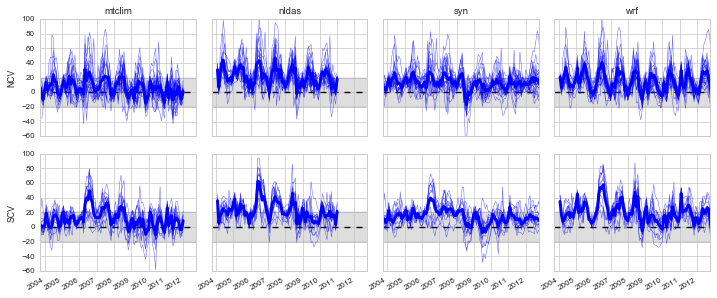

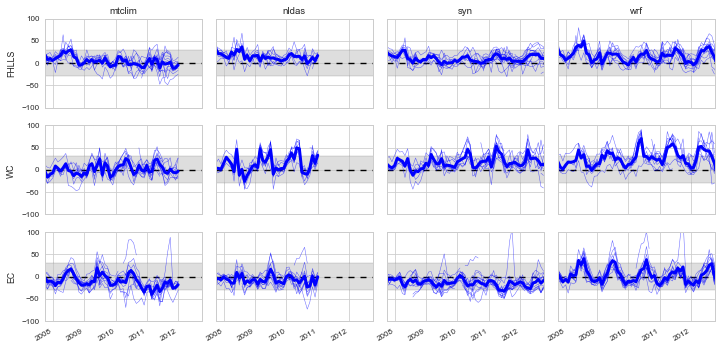

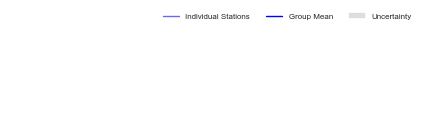

In [6]:
############################################################################################
##      Time series of bias by Grouping - Panel w/ Uncertainty, Valley vs Mountain        ##
############################################################################################
# formating preface
grouping_shortlabel = {'north cv':'NCV','south cv':'SCV','foothills':'FHLLS','west of crest':'WC','east of crest':'EC'}
grouping_uncertainty = {'north cv':20,'south cv':20,'foothills':30,'west of crest':30,'east of crest':30}
colsche = kgraph.SRON(5)
# Figure
fig = plt.figure(figsize=(12,5))
gs = matplotlib.gridspec.GridSpec(2,4)
gs.update(wspace=0.1)
gs.update(hspace=0.15)
# Date limits
d1 = datetime(2003,10,1)
d2 = datetime(2012,10,1)

#### Valley
grouping = ['north cv','south cv']
for n,gr in enumerate(grouping):
    for m,pr in enumerate(pr_names):
        if pr == 'grobs':
            continue
        ax = plt.subplot(gs[n,m])
        
        ###################
        # Shortwave Bias ##
        ###################
        ## Format Qsi bias
        ds_plot = (grobs[pr]-grobs.grobs)
        ds_plot = ds_plot.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
 
        # Uncertainty estimate
        ax.fill_between(ds_plot.time.values,-grouping_uncertainty[gr],grouping_uncertainty[gr],\
                        facecolor='.75',alpha=.5)
        # Zero line
        ax.plot(np.array([d1,d2]),np.array([0,0]),'k--')
        # Each station
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],\
                color='b',alpha=.6,lw=.5)
        # Group mean
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='b',lw=3)
  
        # Labels - products
        if n == 0:
            ax.set_title(pr)
        # Labels - groups
        if m == 0:
            ax.set_ylabel(grouping_shortlabel[gr])
        else:
            ax.yaxis.set_ticklabels([])
        # Legend
        if n == 0 and m == 0:
            ax.legend(ncol=1)
        # Axes limits
        ax.set_xlim(d1,d2)
        ax.set_ylim(-60,100)

fig.autofmt_xdate()
   
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.AllGroups.Uncertainty.Valley.pdf'
fig.savefig(fname)

#### Mountain
grouping = ['foothills','west of crest','east of crest']
# Figure
fig = plt.figure(figsize=(12,6))
gs = matplotlib.gridspec.GridSpec(3,4)
gs.update(wspace=0.09)
# Date limits
d1 = datetime(2007,10,1)
d2 = datetime(2012,10,1)
for n,gr in enumerate(grouping):
    for m,pr in enumerate(pr_names):
        if pr == 'grobs':
            continue
        ax = plt.subplot(gs[n,m])
        
        ###################
        # Shortwave Bias ##
        ###################
        ## Format Qsi bias
        ds_plot = (grobs[pr]-grobs.grobs)
        ds_plot = ds_plot.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
 
        # Uncertainty estimate
        ax.fill_between(ds_plot.time.values,-grouping_uncertainty[gr],grouping_uncertainty[gr],\
                        facecolor='.75',alpha=.5)
        # Zero line
        ax.plot(np.array([d1,d2]),np.array([0,0]),'k--')
        # Each station
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],\
                color='b',alpha=.6,lw=.5)
        # Group mean
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='b',lw=3)
  
        # Labels - products
        if n == 0:
            ax.set_title(pr)
        # Labels - groups
        if m == 0:
            ax.set_ylabel(grouping_shortlabel[gr])
        else:
            ax.yaxis.set_ticklabels([])
        # Legend
        if n == 0 and m == 0:
            ax.legend(ncol=1)
        # Axes limits
        ax.set_xlim(d1,d2)
        ax.set_ylim(-100,100)

fig.autofmt_xdate()
   
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.AllGroups.Uncertainty.Mountain.pdf'
fig.savefig(fname)
        
## Legend
## Legend (separate figure)
leg_fig = plt.figure(figsize=(7,2))
leg_ax = plt.axes()
leg_ax.axis('off')

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
label = ['Individual Stations','Group Mean']
alpha = np.array([.6,1])
h = [mlines.Line2D([],[],color='b',label=lab, alpha=a) \
            for a,lab in zip(alpha,label)]
h.append(mpatches.Patch(color='.75',alpha=.5, label='Uncertainty'))
_out = leg_ax.legend(handles=h,borderaxespad=0.,ncol=3)
leg_fig.savefig('SWdwn_bias_monthly.AllGroups.Uncertainty.Legend.pdf')

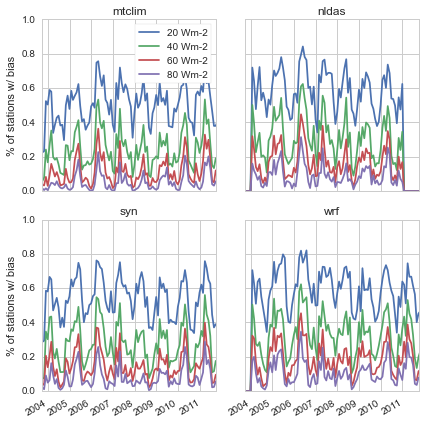

In [41]:
#########################################################
##         Observation error magnitude w/ time         ##
#########################################################
# formating preface
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
grouping_shortlabel = ['NCV','SCV','FHLLS','WC','EC']
colsche = kgraph.SRON(5)

fig,axes = plt.subplots(2,2,sharex='col',sharey='row',figsize=(6,6))
n = (~np.isnan(grobs.grobs)).sum('station').resample(freq='M', dim='time', how='mean').values.astype('float')
t_month = grobs.resample(freq='M', dim='time', how='mean').time
for er in np.arange(20,100,20):
    for ax,pr in zip(axes.flatten(),pr_names):
        # Number of obs per time step exceeding given bias, er
        excede = (np.abs(grobs[pr]-grobs.grobs) > er).sum('station').\
                    resample(freq='M', dim='time', how='mean').values.astype("float")
        excede_percent = excede/n
        
        # Plot time series
        ax.plot(t_month,excede_percent,label=str(er)+' Wm-2')
        
        # Fomat
        ax.set_title(pr)
        ax.set_ylim(0,1)
        ax.set_xlim(datetime(2003,10,1),datetime(2011,10,1))
        if ax == axes[0][0] or ax == axes[1][0]:
            ax.set_ylabel('% of stations w/ bias')
        if ax == axes[0][0]:
            ax.legend(loc='best',frameon=True)
fig.autofmt_xdate()
fig.tight_layout()

os.chdir(dir_print)
fig.savefig('Grobs.ErrorExceedance.png')

#### % of observations exceeding bias level
Errors peak in the spring and diminish as we enter late summer/fall, synchronous across all products

Fairly incomprehenislbe graphs when splitting by station group. The above aggregation across all groups is simpler and more informative.


/Users/karllapo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.


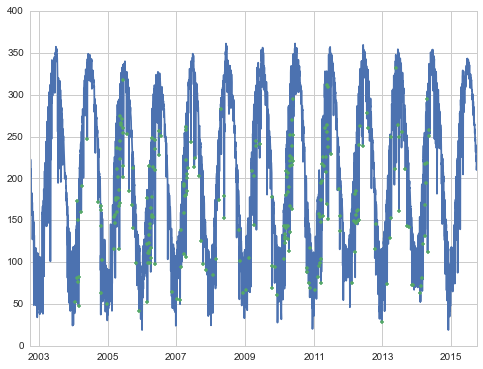

In [21]:
#### Dates of synchronous errors across all products
# Needs to be redone to match above code

er = 80
val2 = np.array(-9999)
n = (~np.isnan(grobs.grobs)).sum('station').values.astype('float')
for pr in pr_names:
    # Number of obs per time step exceeding given bias, er
    excede = (np.abs(grobs[pr]-grobs.grobs) > er).sum('station').values.astype("float")
    excede_percent = excede/n
    val1 = grobs.time.values[ np.nonzero( excede_percent > .3)]
    if val2.size > 0 and not val2 == -9999:
        outdates = np.intersect1d(val1,val2)
        val2 = val1
    else:
        val2 = val1

fig = plt.figure(figsize=(8,6))
plt.plot(grobs.time,grobs.grobs.mean('station'))
plt.plot(outdates,grobs.grobs.loc[{'time':outdates}].mean('station'),'.')

In [40]:
#### Output dates for http://www.esrl.noaa.gov/psd/cgi-bin/data/narr/plotday.pl/ compositing
# Format date strings
d = []
for dout in outdates:
    ts = pd.to_datetime(str(dout)) 
    d.append(ts.strftime('%Y%m%d'))

# Print dates to text file
# Re-write formatted output
os.chdir(dir_data)
fdatesout = open('BadDates.CalRad.txt','w')
fdatesout.write(str(len(d))+'\n')
for i in d:
    fdatesout.write(i+'\n')
fdatesout.close()